In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import random

import pandas as pd

In [2]:
# GPU/CPU setting
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cpu


In [3]:
# import dataset
import yfinance as yf

aapl = yf.download('AAPL', start='2019-01-01', end='2023-12-31')
aapl
# 시작가, 최고가, 최저가, 종가, 장외가, 주식거래량 (6가지 정보)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.793777,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.029236,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.481926,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.402946,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.077835,164101200
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542831,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.642548,48087700


<Axes: xlabel='Date'>

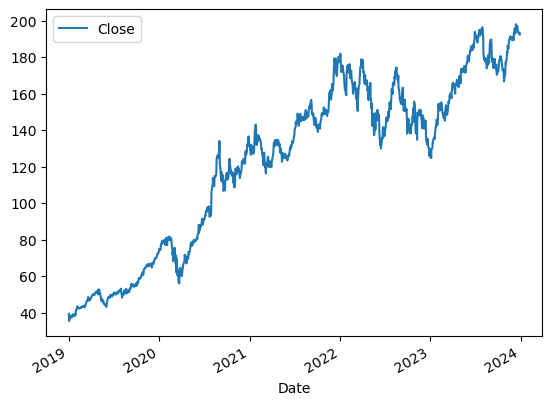

In [4]:
# data가 dataFrame 형태로 되어있고,
# 그 중에서 close price만 가져옴.

df_aapl = pd.DataFrame(aapl['Close'])
df_aapl.plot()

In [5]:
# data preprocessing
# model의 입출력으로 사용하기 위해 처리하는 단계

from sklearn.preprocessing import MinMaxScaler

data_aapl = df_aapl.values
scaler = MinMaxScaler(feature_range=(0,1)) # 0~1의 값으로 scaling
data_aapl = scaler.fit_transform(data_aapl)

# 데이터간의 관계가 존재하기 때문에 다른 모델처럼 임의로 data를 나눠 train과 test에 사용하는 것이 아닌
# 기간을 나눠 train, test data로 사용
# 이번 실습에서는 5년치 데이터 중 4년치로 학습한 후 1년치의 예측이 잘 되는지로 확인
train_ratio = 0.8
split = int(train_ratio * len(data_aapl))
aapl_train = data_aapl[:split, :]
aapl_test = data_aapl[split:, :]

print(aapl_train.shape)
print(aapl_test.shape)

(1006, 1)
(252, 1)


In [6]:
# 10일동안의 종가 변화를 보고 1일의 종가를 예측
# 즉, sequence_length는 이전 몇개의 data를 보고 예측을 할거냐 결정
sequence_length = 10

x_train, y_train = [], []
for i in range(sequence_length, len(aapl_train)):
    # window sliding 형태로 구성 (1일씩 이동)
    x_train.append(aapl_train[i-sequence_length:i, 0])
    y_train.append(aapl_train[i, 0])
    
x_test, y_test = [], []
for i in range(sequence_length, len(aapl_test)):
    x_test.append(aapl_test[i-sequence_length:i, 0])
    y_test.append(aapl_test[i, 0])

# demension을 맞춘 후 최종 FloatTensor로 변환
x_train = np.array(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train = torch.FloatTensor(x_train)
y_train = np.array(y_train)
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_train = torch.FloatTensor(y_train)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test = torch.FloatTensor(x_test)
y_test = np.array(y_test)
y_test = np.reshape(y_test, (y_test.shape[0], 1))
y_test = torch.FloatTensor(y_test)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([996, 10, 1]) torch.Size([996, 1]) torch.Size([242, 10, 1]) torch.Size([242, 1])


In [7]:
# Batch generation
batch_size = 20

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.num_layers = num_layers
        self.device = device
        # batch_first : batch index를 앞에 둘거냐에 대한 opt
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid())
        
    def forward(self, x):
        # h0 : hidden state를 저장하는 Tensor (3차원)
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        
        return out

In [9]:
# create model
input_size = 1
num_layers = 2
hidden_size = 5

model = RNN(input_size=input_size, hidden_size=hidden_size, sequence_length=sequence_length, num_layers=num_layers, device=device).to(device)
model

RNN(
  (rnn): RNN(1, 5, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=50, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [14]:
# Setting Hyperparameters
num_epochs = 200
learning_rate = 0.01

criterion = nn.MSELoss() # regression에서 사용되는 loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# model train
loss_list = []

for epoch_num in range(num_epochs):
    average_cost = 0
    
    for batch_idx, (x_data, y_label) in enumerate(train_loader):
        num_of_mini_batch = len(train_loader)
        x_data = x_data.to(device)
        label = y_label.to(device)
        
        optimizer.zero_grad()
        y_predict = model(x_data)
        loss = criterion(y_predict, label)
        loss.backward()
        optimizer.step()
        
        average_cost = average_cost + (loss.item() / num_of_mini_batch)
        loss_list.append(list)
        
    print("Epoch {} Loss {:.5f}".format((epoch_num + 1), average_cost))

Epoch 1 Loss 0.04677
Epoch 2 Loss 0.18448
Epoch 3 Loss 0.17630
Epoch 4 Loss 0.27833
Epoch 5 Loss 0.11553
Epoch 6 Loss 0.03920
Epoch 7 Loss 0.01754
Epoch 8 Loss 0.23215
Epoch 9 Loss 0.10278
Epoch 10 Loss 0.07769
Epoch 11 Loss 0.04873
Epoch 12 Loss 0.13633
Epoch 13 Loss 0.03850
Epoch 14 Loss 0.31089
Epoch 15 Loss 0.01456
Epoch 16 Loss 0.26045
Epoch 17 Loss 0.01768
Epoch 18 Loss 0.00648
Epoch 19 Loss 0.00941
Epoch 20 Loss 0.01200
Epoch 21 Loss 0.01156
Epoch 22 Loss 0.01052
Epoch 23 Loss 0.00870
Epoch 24 Loss 0.00755
Epoch 25 Loss 0.00790
Epoch 26 Loss 0.00719
Epoch 27 Loss 0.00623
Epoch 28 Loss 0.00549
Epoch 29 Loss 0.00515
Epoch 30 Loss 0.00515
Epoch 31 Loss 0.00507
Epoch 32 Loss 0.00506
Epoch 33 Loss 0.00507
Epoch 34 Loss 0.00510
Epoch 35 Loss 0.00514
Epoch 36 Loss 0.00512
Epoch 37 Loss 0.00518
Epoch 38 Loss 0.00496
Epoch 39 Loss 0.00559
Epoch 40 Loss 0.00449
Epoch 41 Loss 0.00639
Epoch 42 Loss 0.00733
Epoch 43 Loss 0.01179
Epoch 44 Loss 0.01679
Epoch 45 Loss 0.00570
Epoch 46 Loss 0.005

In [12]:
# validation
with torch.no_grad():
    num_total_data = 0
    correct = 0
    for batch_idx, (data, labels) in enumerate(test_loader):
        num_of_mini_batch = len(test_loader)
        
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        average_cost = average_cost + (loss.item() / num_of_mini_batch)
        loss_list.append(loss)
    
print("Test Loss {:.5f}".format(average_cost))

Test Loss 0.01412


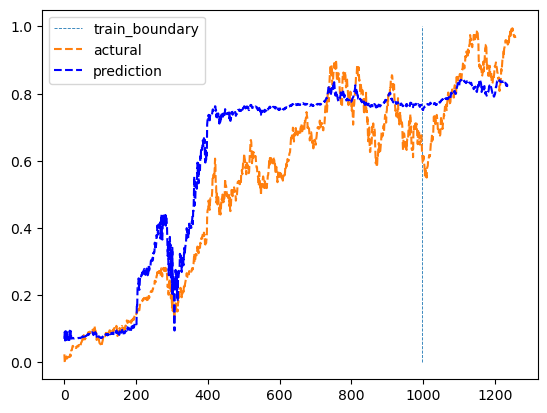

In [18]:
# visualization (plot)
with torch.no_grad():
    train_pred = []
    test_pred = []
    
    for batch_idx, (x_data, y_label) in enumerate(train_loader):
        x_data = x_data.to(device)
        label = y_label.to(device)
        y_predict = model(x_data)
        train_pred += y_predict.cpu().numpy().tolist()
        
    for batch_idx, (x_data, y_label) in enumerate(test_loader):
        x_data = x_data.to(device)
        label = y_label.to(device)
        y_predict = model(x_data)
        test_pred += y_predict.cpu().numpy().tolist()
        
total = train_pred + test_pred
plt.figure()
plt.plot(np.ones(100)*len(train_pred), np.linspace(0, 1, 100), '--', linewidth=0.6)
plt.plot(data_aapl, '--')
plt.plot(total, 'b--')
plt.legend(['train_boundary', 'actural', 'prediction'])
plt.show()